In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
from urllib.request import urlretrieve
import os

In [ ]:
soup = BeautifulSoup(requests.get("https://download.geofabrik.de/europe/germany.html").content)

In [ ]:
subregions = ["https://download.geofabrik.de/europe/" + subregion["href"] for subregion in soup.find_all("a", href = re.compile("germany/.*\.html"))]

In [ ]:
lookup_table = pd.DataFrame(columns = ["subregion", "subsubregion", "path", "link"])

In [ ]:
storage_directory = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/raw"

In [ ]:
dl_links

In [ ]:
[{"subregion": re.search(r"^.*(?=/)|^.*(?=-latest)", dl_link).group(0),
                                        #    "subsubregion": re.search(r"(?<=/)*.*(?=-regbez)*(?=-latest)", dl_link).group(0),
                                           "link": f"https://download.geofabrik.de/europe/germany/{dl_link}"} for dl_link in dl_links]

In [ ]:
subregions = subregions[1:]

In [ ]:
os.makedirs(f"{storage_directory}/{re.search(r'^.*(?=/)|^.*(?=-latest)', dl_link).group(0)}", exist_ok = True)

In [ ]:
# iterate the subregions
for subregion in subregions:
    add_subregion_path = False
    
    # get the page for the subregion
    soup = BeautifulSoup(requests.get(subregion).content)
    
    # check if there are no subsubregions
    if (len(soup.find_all("p", string = re.compile("No sub regions are defined for this region."))) > 0):
        add_subregion_path = True
        # add the entire subregion to the download query
        dl_links = [soup.find("a", href = re.compile(".*latest\.osm\.pbf$"))["href"]]
        
    else:
        # add all subsubregions to the download query
        dl_links = [subsubregion["href"] for subsubregion in soup.find_all("a", href = re.compile(".*/.*\.osm\.pbf$"))]
        
        
    # add the links to the lookup table
    lookup_table = pd.concat([lookup_table,
                            pd.DataFrame([{"subregion": re.search(r"^.*(?=/)|^.*(?=-latest)", dl_link).group(0),
                                           "subsubregion": re.search(r"(?<=/)*.*(?=-regbez)*(?=-latest)", dl_link).group(0),
                                           "path": f"{storage_directory}/{re.search(r'^.*(?=/)|^.*(?=-latest)', dl_link).group(0)}/{dl_link}",
                                           "link": f"https://download.geofabrik.de/europe/germany/{dl_link}"} for dl_link in dl_links])])
    
    # create the directory for the subsubregion
    os.makedirs(f"{storage_directory}/{re.search(r'^.*(?=/)|^.*(?=-latest)', dl_links[0]).group(0)}", exist_ok = True)
    
    # iterate over download links
    #for dl_link in dl_links:
    #    # download the file
    #    if add_subregion_path:
    #        urlretrieve(f"https://download.geofabrik.de/europe/germany/{dl_link}",
    #                        f"{storage_directory}/{re.search(r'^.*(?=/)|^.*(?=-latest)', dl_link).group(0)}/{dl_link}")
    #    else:
    #        urlretrieve(f"https://download.geofabrik.de/europe/germany/{dl_link}",
    #                        f"{storage_directory}/{dl_link}")
    
    lookup_table.to_csv(f"{storage_directory}/lookup.csv")

In [ ]:
lookup_table

In [ ]:
urlretrieve(f"https://download.geofabrik.de/europe/germany/{level}.json",
                        f"{storage_directory}/gadm41_DEU_{level}.json")

# Evalutate some problems with the current OSM processing

In [48]:
import pandas as pd
import shapely

In [83]:
import geopandas as gpd
driveways = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg.geojson")

In [46]:
pd.DataFrame(dict(x = [0, 1], y = [driveways.loc[driveways["index"] == driveways["index"][0],"index"], driveways.loc[driveways["index"] == "","index"]])).iloc[0,1][0]

'[   0    1    2  447  448  575  606  607  837  838 1286 1329 1535 1536\n 1760 1761 1866 1867]'

In [87]:
driveways.group.value_counts()

[ 411  791  881  882  883  884  885  886  887  888  889  890  911  927\n  928  929 1361 1606]                                                                                                                                     43
[ 273  633  691 1011 1012 1013 1014 1015 1016 1017 1019 1021 1023 1024\n 1025 1026 1028 1029 1030 1464 1465 1466 1467 1468 1469 1470 1670 1671\n 1688 1998 2013 2014]                                                             34
[ 775  776  777  778  779  819  821  825  826  827  840  841  842  843\n  844  845  846  847  848 1086 1111 1118 1288 1289 1525 1526 1545 1546\n 1615 1794 1898 1899 1900 1901 1902 1903 1904 1929 1930 1941 1942 1943\n 2052]    31
[ 272  274  275  276  277  328  329  423  523  539  579  760  761  792\n  835  836  851  852  964  965 1124 1149 1171 1567 1680 1874 1886 1887\n 2059 2060 2061 2070]                                                             29
[ 387  473  474  595  596  677  678  679  680  731  732  733 1144 1436\n 1447 1448 1

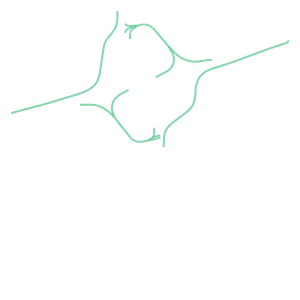

In [88]:
driveways.geometry[5]

It looks like the close ramps were not properly dissolved

In [5]:
import shapely
bboxes_polygons = driveways.bounds.apply(lambda bbox: shapely.geometry.Polygon([(bbox[0], bbox[1]),
                          (bbox[0], bbox[3]),
                          (bbox[2], bbox[3]),
                          (bbox[2], bbox[1])]), axis = 1)

In [3]:
test = driveways.loc[bboxes_polygons.apply(lambda x: bboxes_polygons[5].intersects(x))].dissolve()

# Problem: Not fully dissolved, check grouping
# @TODO: debug grouping and dissolving in data_driveways

In [4]:
test_bounds = test.bounds.apply(lambda bbox: shapely.geometry.Polygon([(bbox[0], bbox[1]),
                          (bbox[0], bbox[3]),
                          (bbox[2], bbox[3]),
                          (bbox[2], bbox[1])]), axis = 1)

In [154]:
test.bounds

,minx,miny,maxx,maxy
0,413807.877397,5.797070e+06,417036.300148,5.798567e+06


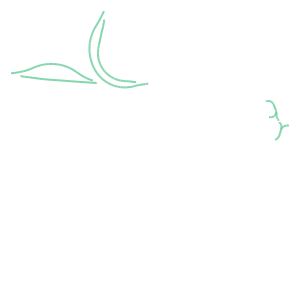

In [53]:
test.geometry[0]

This has fully dissolved them

Next I get the street data from the OSM file

In [7]:
import pyrosm as psm

In [8]:
# Initialize the OSM parser object
osm = psm.OSM("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/raw/brandenburg/brandenburg-latest.osm.pbf")

In [9]:
# Filter the OSM data for driveways
grid = osm.get_data_by_custom_criteria(custom_filter={"highway": ["motorway"]},
                                # Keep data matching the criteria above
                                filter_type="keep",
                                # Do not keep nodes (point data)    
                                keep_nodes=False, 
                                keep_ways=True, 
                                keep_relations=True)

In [10]:
grid = grid.to_crs(25833)

In [13]:
grid.to_file("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/research/notebooks/test.geojson")

On reruns, import here:

In [33]:
grid = gpd.read_file("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/research/notebooks/test.geojson")

Now plot both road types combined

In [6]:
import matplotlib.pyplot as plt

In [6]:
# get those sections of the main road that intersect with the bboxes of the turnoffs
test_3 = grid.loc[grid.geometry.apply(lambda x: test_bounds[0].intersects(x))]

<AxesSubplot: >

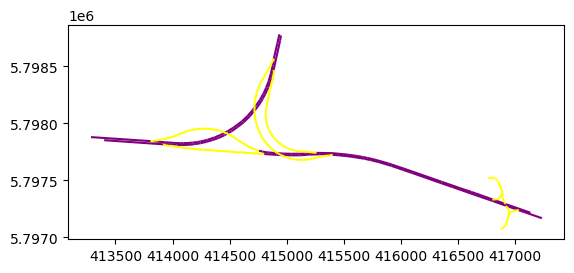

In [146]:
fig, ax = plt.subplots()
test_3.plot(ax = ax, color = "purple")
test.plot(ax = ax, color = "yellow")

---
# Plots for the presentation

In [1]:
def make_bounding_box(bbox):
        polygon = shapely.geometry.Polygon([(bbox[0], bbox[1]),
                                            (bbox[0], bbox[3]),
                                            (bbox[2], bbox[3]),
                                            (bbox[2], bbox[1])]).buffer(20)
        return polygon

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
driveways = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg.geojson")

In [8]:
borders_1 = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/borders/gadm41_DEU_1.json")
borders_2 = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/borders/gadm41_DEU_2.json")


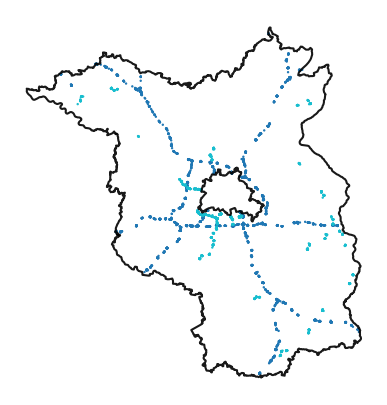

In [38]:
fig, ax = plt.subplots(figsize = (10, 5))
borders_1.loc[borders_1.GID_1 == "DEU.4_1"].boundary.plot(ax = ax, color = "black", alpha = .9)
#borders_2.loc[borders_2.GID_1 == "DEU.4_1"].boundary.plot(ax = ax, color = "black", alpha = .5)

overview = driveways.copy()
overview["geometry"] = overview.geometry.apply(lambda x: x.centroid)
overview.plot(ax = ax, column = "link_type", markersize = .5)
ax.set_axis_off()
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/brandenburg_driveways.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

In [3]:
example_link_ids = driveways.loc[driveways.id.isin([4913908, 152141468]), "link_id"]

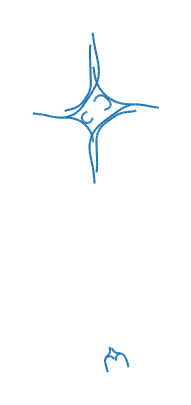

In [23]:
fig, ax = plt.subplots(figsize = (10, 5))
example_links = driveways.loc[((driveways.link_id.isin(example_link_ids)) & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))]
example_links.plot(ax = ax)
ax.set_axis_off()
ax.set_xlim([bboxes_links_offset.total_bounds[0], bboxes_links_offset.total_bounds[2]])
ax.set_ylim([bboxes_links_offset.total_bounds[1], bboxes_links_offset.total_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_1.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

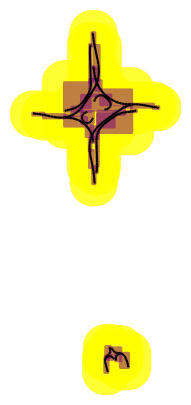

In [22]:
fig, ax = plt.subplots(figsize = (10, 5))
bboxes_links = example_links.copy()
bboxes_links["geometry"] = bboxes_links.geometry.bounds.apply(make_bounding_box, axis = 1)
bboxes_links_offset = example_links.copy()
bboxes_links_offset["geometry"] = bboxes_links_offset.geometry.bounds.apply(make_bounding_box, axis = 1).apply(lambda x: x.buffer(250))
bboxes_links_offset.plot(ax = ax, color = "yellow", alpha = .8)
bboxes_links.plot(ax = ax, color = "purple", alpha = .5)
example_links.plot(ax = ax, color = "black")
ax.set_axis_off()
ax.set_xlim([bboxes_links_offset.total_bounds[0], bboxes_links_offset.total_bounds[2]])
ax.set_ylim([bboxes_links_offset.total_bounds[1], bboxes_links_offset.total_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_2.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

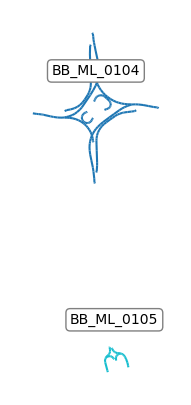

In [24]:
example_links_dissolved = example_links.dissolve(by = "link_id", as_index=False)
#example_links_dissolved.geometry.bounds.apply(make_bounding_box, axis = 1)
fig, ax = plt.subplots(figsize = (10, 5))
example_links_dissolved.plot(ax = ax, column = "link_id")

example_links_dissolved['coords'] = example_links_dissolved['geometry'].apply(lambda x: x.centroid.coords[:])
example_links_dissolved['coords'] = [coords[0] for coords in example_links_dissolved['coords']]
for idx, row in example_links_dissolved.iterrows():
    ax.annotate(text=row['link_id'], xy=tuple([row['coords'][0], row['coords'][1] + 400]),
                bbox=dict(boxstyle="round", fc="white", ec="gray"),
                 horizontalalignment='center')
ax.set_axis_off()
ax.set_xlim([bboxes_links_offset.total_bounds[0], bboxes_links_offset.total_bounds[2]])
ax.set_ylim([bboxes_links_offset.total_bounds[1], bboxes_links_offset.total_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_3.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

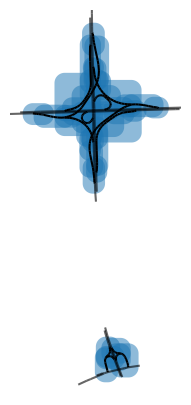

In [25]:
fig, ax = plt.subplots(figsize = (10, 5))
example_links = driveways.loc[((driveways.link_id.isin(example_link_ids)) & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))]
example_links.plot(ax = ax, color = "black")

bboxes_links = example_links.copy()
bboxes_links["geometry"] = bboxes_links.geometry.bounds.apply(make_bounding_box, axis = 1).apply(lambda x: x.buffer(100))
bboxes_links.plot(ax = ax, alpha = .5)

driveways.loc[((driveways.link_id.isin(example_link_ids)) & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].\
    plot(ax = ax, color = "black", alpha = .6)
    
ax.set_axis_off()
ax.set_xlim([bboxes_links_offset.total_bounds[0], bboxes_links_offset.total_bounds[2]])
ax.set_ylim([bboxes_links_offset.total_bounds[1], bboxes_links_offset.total_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_4.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

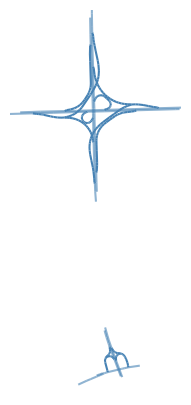

In [26]:
fig, ax = plt.subplots(figsize = (10, 5))

example_links = driveways.loc[((driveways.link_id.isin(example_link_ids)) & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))]
example_links.plot(ax = ax, color = "steelblue")
driveways.loc[((driveways.link_id.isin(example_link_ids)) & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].\
    plot(ax = ax, color = "steelblue", alpha = .6)
    
ax.set_axis_off()
ax.set_xlim([bboxes_links_offset.total_bounds[0], bboxes_links_offset.total_bounds[2]])
ax.set_ylim([bboxes_links_offset.total_bounds[1], bboxes_links_offset.total_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_5.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

In [17]:
polygons = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg_polygons.geojson")
polygons_example = polygons.loc[(polygons.link_id == "BB_ML_0104")].copy().reset_index(drop = True)

In [4]:
import xarray
import rioxarray
xf = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/raw/BB_ML_0104_2017-06-02.nc")

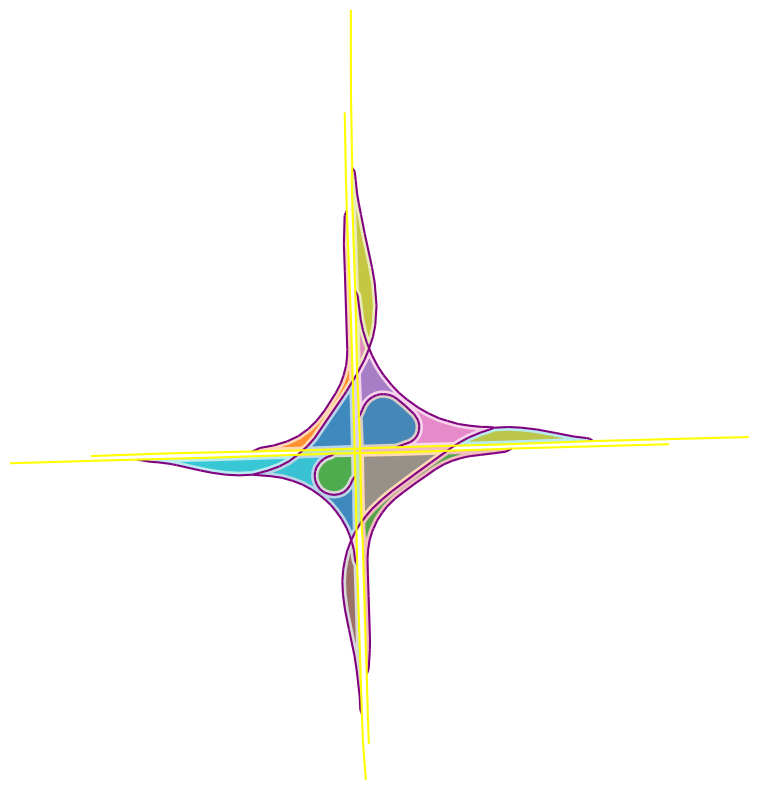

In [28]:
fig, ax = plt.subplots(figsize = (10, 10))

import matplotlib
cmap = matplotlib.cm.get_cmap('tab20c')
polygons_example["color"] = [cmap(x) for x in polygons_example.index]
polygons_example.plot(column = "color", ax = ax, alpha = .3)

polygons_example_offset = polygons_example.copy()
polygons_example_offset["geometry"] = polygons_example_offset.geometry.apply(lambda x: x.buffer(-12))
polygons_example_offset.plot(column = "color", ax = ax, alpha = .8)

driveways.loc[((driveways.link_id == "BB_ML_0104") & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "purple")
driveways.loc[((driveways.link_id == "BB_ML_0104") & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "yellow")

im_bounds = driveways.loc[((driveways.link_id == "BB_ML_0104") & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].total_bounds

ax.set_axis_off()
ax.set_xlim([im_bounds[0], im_bounds[2]])
ax.set_ylim([im_bounds[1], im_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_6.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

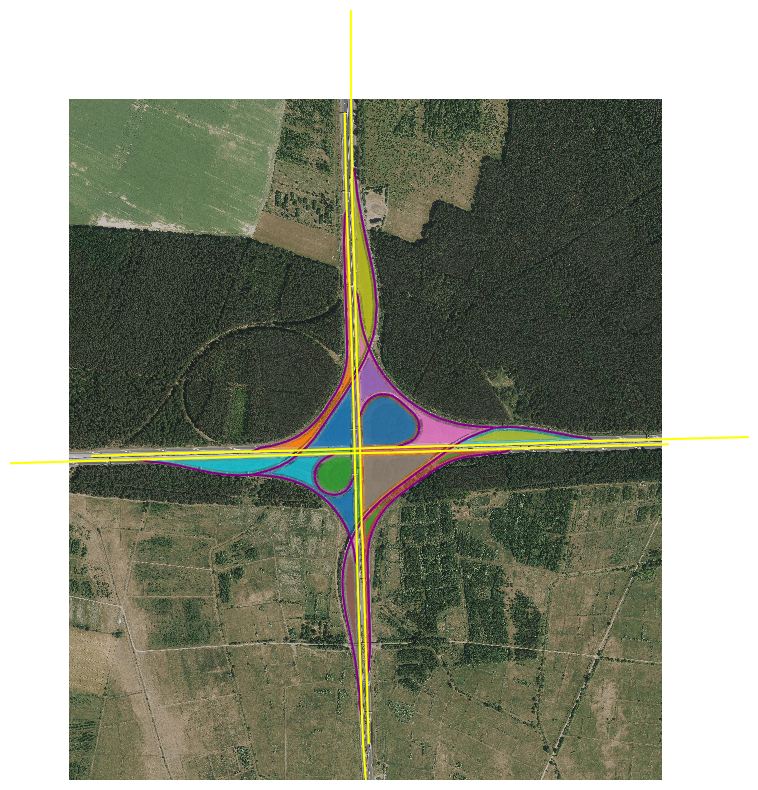

In [29]:
fig, ax = plt.subplots(figsize = (10, 10))

xarray.plot.imshow(xf.drop("spatial_ref").sel(band=1).to_array("band").astype("int"), rgb = "band", ax = ax, add_colorbar=False)

import matplotlib
cmap = matplotlib.cm.get_cmap('tab20c')
polygons_example["color"] = [cmap(x) for x in polygons_example.index]
polygons_example.plot(column = "color", ax = ax, alpha = .5)

polygons_example_offset = polygons_example.copy()
polygons_example_offset["geometry"] = polygons_example_offset.geometry.apply(lambda x: x.buffer(-12))
polygons_example_offset.plot(column = "color", ax = ax, alpha = .8)

driveways.loc[((driveways.link_id == "BB_ML_0104") & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "purple")
driveways.loc[((driveways.link_id == "BB_ML_0104") & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "yellow")

ax.set_axis_off()
ax.set_xlim([im_bounds[0], im_bounds[2]])
ax.set_ylim([im_bounds[1], im_bounds[3]])
fig.savefig("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/presentations/fig/driveways_example_7.jpg",
            bbox_inches='tight', pad_inches=0, dpi = 300)

---

In [33]:
import pandas as pd
import geopandas as gpd

data = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg_polygons.geojson")

In [42]:
tmp = data.geometry.apply(lambda x: x.buffer(-12) if x is not None else None)
tmp.area.sum()

6607510.155949145

6607510.155949145

<AxesSubplot: >

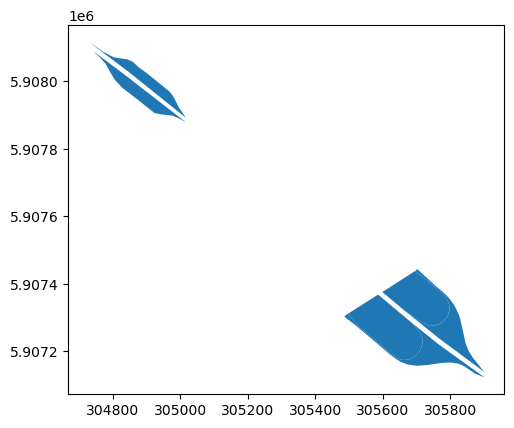

In [7]:
data[data.link_id == "BB_ML_0005"].plot()

---

In [30]:
import pandas as pd
import geopandas as gpd

data = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg.geojson")

In [2]:
data_old = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg copy.geojson")

In [3]:
test = data.groupby("link_id").id.agg("first")

In [4]:
mapping = test.apply(lambda x: data_old.loc[data_old.id == x, "link_id"].reset_index(drop = True))[0]

In [5]:
import os
import re
filenames = os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/raw")
filenames = [re.compile("(?<=_\d\d\d\d)_").split(x) for x in filenames]

In [10]:
base_path = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/raw/"
for name_new in mapping.index:
    for it_filename in filenames:
        if it_filename[0] == mapping[name_new]:
            #print(it_filename[0] + "_" + it_filename[1], name_new + "_"+ it_filename[1])
            os.rename(base_path + it_filename[0] + "_" + it_filename[1], base_path + name_new + "_"+ it_filename[1])

---

In [2]:
import pandas as pd
import geopandas as gpd
import pyrosm as psm

In [3]:
# Initialize the OSM parser object
osm = psm.OSM("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/raw/brandenburg/brandenburg-latest.osm.pbf")

In [5]:
# Filter the OSM data for driveways
substations = osm.get_data_by_custom_criteria(custom_filter = {"power": ["substation"]},
                                # Keep data matching the criteria above
                                filter_type="keep",
                                # Do not keep nodes (point data)    
                                keep_nodes=True, 
                                keep_ways=True, 
                                keep_relations=True)

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/pyrosm/pyrosm.py:689: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_user_defined_data(
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [25]:
substations_filtered = substations.copy().loc[((~substations.substation.isna()) & (substations.osm_type == "way")),:].to_crs("25833")

In [26]:
substations_filtered.geometry = substations_filtered.centroid

---

<AxesSubplot: >

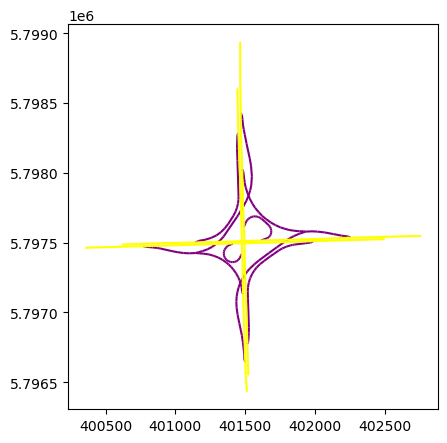

In [93]:
fig, ax = plt.subplots(figsize = (10, 5))
driveways.loc[((driveways.link_id == "BB_ML_0045") & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "purple")
driveways.loc[((driveways.link_id == "BB_ML_0045") & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "yellow")

<AxesSubplot: >

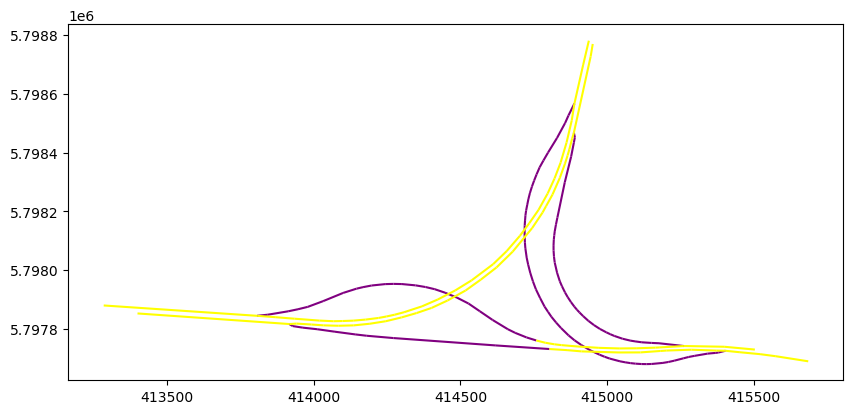

In [75]:
fig, ax = plt.subplots(figsize = (10, 5))
driveways.loc[((driveways.link_id == "BB_ML_0001") & ((driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "purple")
driveways.loc[((driveways.link_id == "BB_ML_0001") & (~(driveways.highway.isin(["motorway_link", "trunk_link"]))))].plot(ax = ax, color = "yellow")

In [73]:
polygons = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg_polygons.geojson")

In [78]:
subset = polygons.loc[polygons.link_id == "BB_ML_0001",:]

<AxesSubplot: >

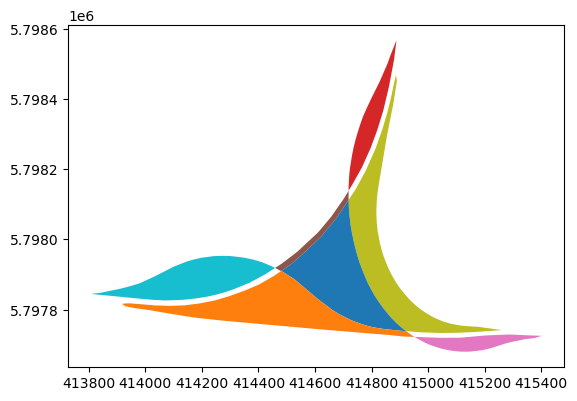

In [81]:
import matplotlib
cmap = matplotlib.cm.get_cmap('tab20c')
subset["color"] = [cmap(x) for x in subset.index]
subset.plot(column = "color")

In [ ]:
class preprocessing_driveways_polygons(): #preprocessing_abstract
    """
    This class turns road line geometries into the smallest non-overlapping polygons
    It is multiprocessing enabled
    """
    
    def __init__(self,
                 storage_directory = "/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/"):

        self.storage_directory = storage_directory
        
        
    def preprocess(self, bundesland):
        
        print("--- Loading Data... ---")

        # import all driveways
        driveways = gpd.read_file(f"{self.storage_directory}OSM/processed/{bundesland}.geojson")
        
        # get the subset of only link roads
        self.link_roads = self.driveways.loc[(self.driveways.highway.isin(["motorway_link", "trunk_link"])),:].copy()
        
        # dissolve both to single graphs
        self.driveways = self.driveways.dissolve(by = "group", as_index = False)
        #link_roads = link_roads.dissolve(by = "group", as_index = False)
        
        self.driveways["polygons"] = self.driveways.geometry.apply(lambda x: list(shapely.ops.polygonize(x)))
        self.driveways.drop(columns = "geometry").explode("polygons").set_geometry("polygons").to_file(f"{self.storage_directory}OSM/processed/{bundesland}_polygons.geojson", driver='GeoJSON')
                
        #print("--- Performing Network Analysis... ---")
                
        #results = [self._preprocess_single(link_id) for link_id in self.driveways.link_id.unique()]
        #results = Parallel(n_jobs = mp_cores, prefer="threads")(delayed(self._preprocess_single)(link_id) for link_id in self.driveways.link_id.unique()) 

        #print("--- Exporting results... ---")

        # concat all results and save
        #pd.concat(results).to_file(f"{self.storage_directory}OSM/processed/{bundesland}_polygons.geojson", driver='GeoJSON')
        
           
    
    
if __name__ == "__main__":
    driveways_polygons_processor = preprocessing_driveways_polygons()
    driveways_polygons_processor.preprocess("brandenburg", mp_cores = 2)

def _preprocess_single(self, link_id):
        
        print("Processing link id: " + link_id)
                
        ## create networks
        # the complete intersection
        geo_graph = momepy.gdf_to_nx(self.driveways.loc[self.driveways.link_id == link_id,:].explode("geometry", index_parts = True).reset_index(), approach = "primal")
        # only the link roads - these are used for initiating the search algorithm
        #starter_nodes = momepy.gdf_to_nx(self.link_roads.loc[self.link_roads.link_id == link_id,"geometry"].apply(lambda x: x.boundary[0]).reset_index(), approach = "primal")
        starter_nodes = nx.MultiGraph()
        
        # greatly speed up if all nodes are connected
        # by only checking for all circles once
        if nx.is_connected(geo_graph):
            starter_nodes.add_node(self.link_roads.loc[self.link_roads.link_id == link_id, "geometry"].\
                apply(lambda x: x.boundary[0].coords[0]).reset_index(drop = True)[0])
        # for disconnected cases check all links
        else:
            for node in self.link_roads.loc[self.link_roads.link_id == link_id,"geometry"].\
                apply(lambda x: x.boundary[0].coords[0]).reset_index(drop = True):
                    starter_nodes.add_node(node)

        # compute all circles in the network and return in reversed order by length
        cycles = sorted(self._find_all_cycles(geo_graph, source = list(starter_nodes.nodes)), key = len)[::-1]
        
        # turn into polygons
        polygons = [shapely.geometry.Polygon(shapely.geometry.Point(node) for node in cycle) for cycle in cycles]
        
        # get all no-overlapping (quasi-unique) circles
        # adapted from @https://stackoverflow.com/a/47503098 with minimal changes
        non_overlapping = []
        for n, p in enumerate(polygons[:-1], 1):
            if not any(p.overlaps(g) for g in polygons[n:]):
                non_overlapping.append(p)
                
        # turn result into GeoDataFrame and return
        return gpd.GeoDataFrame({"link_id": link_id, "geometry": non_overlapping})
    
        
    # A function that finds all circles in a network
    # adapted from @https://gist.github.com/joe-jordan/6548029 with minimal changes
    def _find_all_cycles(self, G, source=None, cycle_length_limit=None):
        """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
        types which work with min() and > ."""
        # produce edges for components with source
        nodes = source
            
        # extra variables for cycle detection:
        cycle_stack = []
        output_cycles = set()
        
        def get_hashable_cycle(cycle):
            """cycle as a tuple in a deterministic order."""
            m = min(cycle)
            mi = cycle.index(m)
            mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
            if cycle[mi-1] > cycle[mi_plus_1]:
                result = cycle[mi:] + cycle[:mi]
            else:
                result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
            return tuple(result)
        
        for start in nodes:
            if start in cycle_stack:
                continue
            cycle_stack.append(start)
            
            stack = [(start,iter(G[start]))]
            while stack:
                parent,children = stack[-1]
                try:
                    child = next(children)
                    
                    if child not in cycle_stack:
                        cycle_stack.append(child)
                        stack.append((child,iter(G[child])))
                    else:
                        i = cycle_stack.index(child)
                        if i < len(cycle_stack) - 2: 
                            output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                    
                except StopIteration:
                    stack.pop()
                    cycle_stack.pop()
        
        return [list(i) for i in output_cycles]

/scratch/slurm_tmpdir/job_21405038/ipykernel_289401/2882313596.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_reduced = gpd.GeoDataFrame(geometry = area_reduced.loc[((area_reduced.area / area_reduced.length ) > 5)])
/scratch/slurm_tmpdir/job_21405038/ipykernel_289401/2882313596.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_reduced = gpd.GeoDataFrame(geometry = area_reduced.loc[((area_reduced.area / area_reduced.length ) > 5)])


<AxesSubplot: >

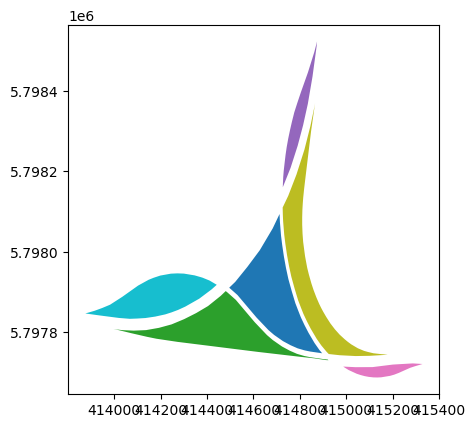

In [98]:
area_reduced = subset.geometry.apply(lambda x: x.buffer(-7))
area_reduced = gpd.GeoDataFrame(geometry = area_reduced.loc[((area_reduced.area / area_reduced.length ) > 5)])
area_reduced["color"] = [cmap(x) for x in area_reduced.index]
area_reduced.plot(column = "color")

In [13]:
link_roads = driveways.loc[((driveways.highway.isin(["motorway_link", "trunk_link"]))),:].copy()
#adjunct_roads = driveways.loc[(~(driveways.highway.isin(["motorway_link", "trunk_link"]))),:].copy()
#del driveways

Next I want to convert the entire system into a network to find circles. For this I first union the network to create nodes at the intersections.

In [63]:
driveways = driveways.dissolve(by = "group", as_index = False)
#link_roads = link_roads.dissolve(by = "group", as_index = False)
driveways["polygons"] = driveways.apply(lambda x: list(shapely.ops.polygonize(x["geometry"])), axis = 1)

<AxesSubplot: >

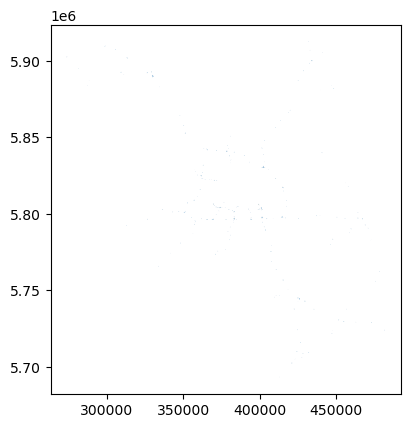

In [70]:
driveways.drop(columns = "geometry").explode("polygons").set_geometry("polygons")

In [15]:
filter_id = "BB_ML_0024" #driveways.link_id.unique()[1]
#"BB_TL_0030" "BB_ML_0113", "BB_ML_0167"!!, "BB_ML_0029", "BB_TL_0290"

In [62]:
.explode()

0      [POLYGON ((329864.0483232797 5890325.172700637...
1      [POLYGON ((415341.34806036385 5797715.81406656...
2      [POLYGON ((348182.0697779549 5780848.106232369...
3      [POLYGON ((401445.4876277203 5843043.098184765...
4      [POLYGON ((352715.95812617673 5807036.70920912...
                             ...                        
333    [POLYGON ((446869.40326978936 5883907.81994050...
334    [POLYGON ((440681.99104556296 5839917.93209273...
335    [POLYGON ((410649.4512144277 5746791.649375081...
336    [POLYGON ((412823.4428920219 5746600.12089478,...
337    [POLYGON ((468833.4280581746 5792553.447438122...
Length: 338, dtype: object

In [60]:
driveways.merge(gpd.GeoSeries(driveways.geometry.apply(lambda x: list(shapely.ops.polygonize(x))).explode()))

,group,geometry,access,area,bicycle,bicycle_road,bridge,busway,cycleway,foot,...,turn,width,id,timestamp,version,tags,osm_type,changeset,link_type,link_id


<AxesSubplot: >

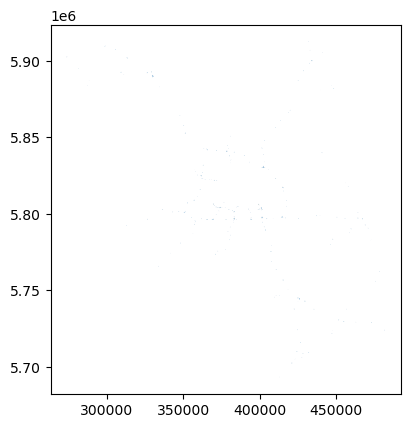

In [44]:
import pandas as pd
pd.concat([gpd.GeoDataFrame(geometry = list(x)) for x in driveways.geometry.apply(shapely.ops.polygonize)])

,geometry
0,"POLYGON ((329864.048 5890325.173, 329851.399 5..."
1,"POLYGON ((329409.468 5890373.408, 329523.584 5..."
2,"POLYGON ((329982.835 5890303.537, 330014.643 5..."
3,"POLYGON ((330014.643 5890299.724, 329982.835 5..."
4,"POLYGON ((329955.775 5890317.087, 329957.292 5..."
...,...
3,"POLYGON ((468878.418 5792691.188, 468909.400 5..."
4,"POLYGON ((468878.418 5792691.188, 468869.141 5..."
5,"POLYGON ((468847.999 5792729.702, 468824.197 5..."
6,"POLYGON ((468780.453 5792603.870, 468775.535 5..."


<AxesSubplot: >

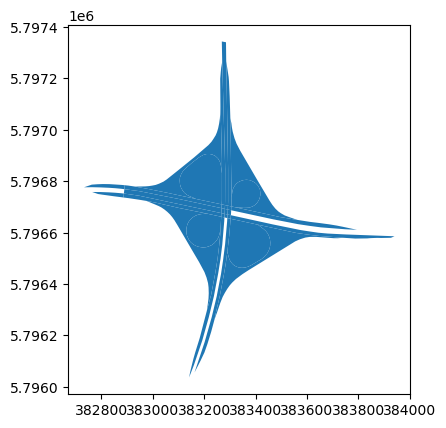

In [39]:
gpd.GeoDataFrame(geometry = list(shapely.ops.polygonize(driveways.loc[driveways.link_id == filter_id,"geometry"]))).plot()

<AxesSubplot: >

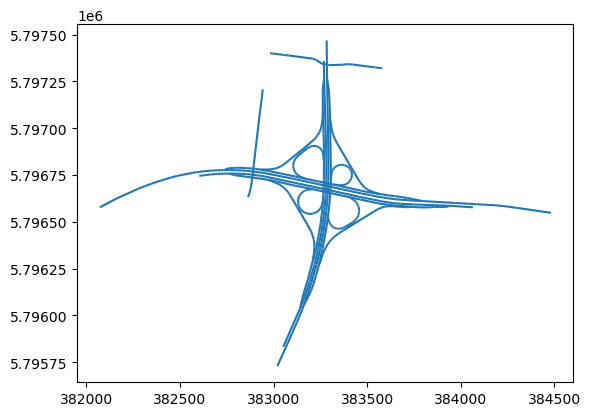

In [3]:
driveways.loc[driveways.link_id == filter_id,:].plot()

In [16]:
import momepy
import networkx as nx
# create a network
geo_graph = momepy.gdf_to_nx(driveways.loc[driveways.link_id == filter_id,:].explode("geometry", index_parts = True).reset_index(), approach = "primal")

In [17]:
nx.is_connected(geo_graph)

True

In [24]:
starter_nodes = momepy.gdf_to_nx(link_roads.loc[link_roads.link_id == filter_id,"geometry"].apply(lambda x: x.boundary[0]).reset_index(), approach = "primal")

/scratch/slurm_tmpdir/job_21402864/ipykernel_1360962/202862768.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  starter_nodes = momepy.gdf_to_nx(link_roads.loc[link_roads.link_id == filter_id,"geometry"].apply(lambda x: x.boundary[0]).reset_index(), approach = "primal")
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/conda/envs/ds_project/lib/python3.10/site-packages/momepy/utils.py:63: RuntimeWarning: The given network does not contain any LineString.. This can lead to unexpected behaviour. The intended usage of the conversion function is with networks made of LineStrings only.
  warnings.warn(


In [26]:
starter_nodes = nx.MultiGraph()
starter_nodes.add_node(link_roads.loc[link_roads.link_id == filter_id, "geometry"].\
    apply(lambda x: x.boundary[0].coords[0]).reset_index(drop = True)[0])

/scratch/slurm_tmpdir/job_21405038/ipykernel_289401/677654899.py:3: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  apply(lambda x: x.boundary[0].coords[0]).reset_index(drop = True)[0])


In [21]:
test = link_roads.loc[link_roads.link_id == filter_id,"geometry"].apply(lambda x: x.boundary[0].coords[0]).reset_index(drop = True)
starter_nodes = nx.MultiGraph()
for node in test:
    starter_nodes.add_node(node)

/scratch/slurm_tmpdir/job_21405038/ipykernel_289401/398966486.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  test = link_roads.loc[link_roads.link_id == filter_id,"geometry"].apply(lambda x: x.boundary[0].coords[0]).reset_index(drop = True)


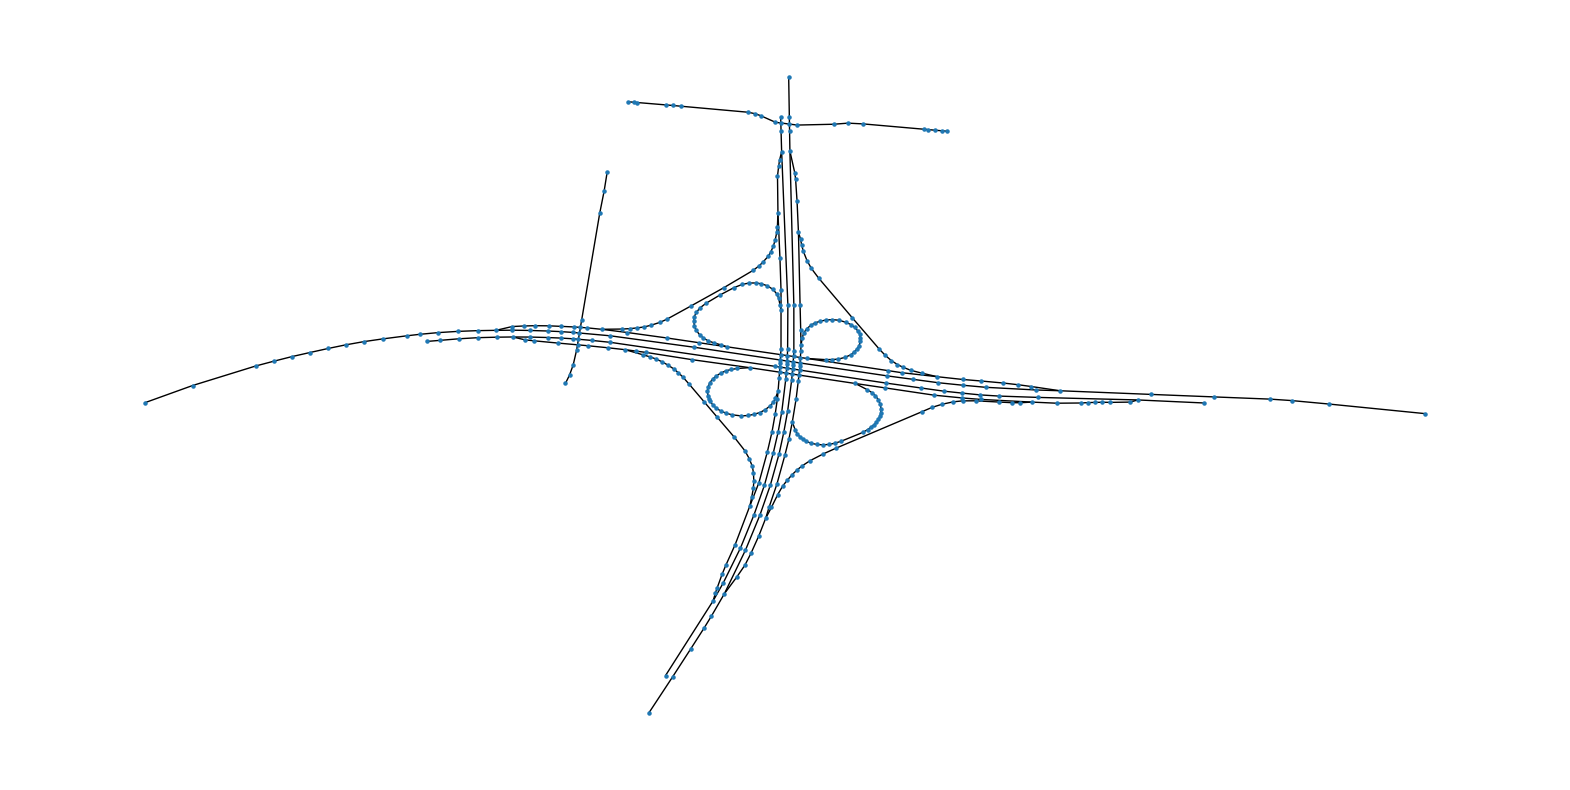

In [18]:
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}
fig, ax = plt.subplots(figsize = (20, 10))
nx.draw(geo_graph, positions, ax=ax, node_size=5)
#ax.set_xlim([413500, 416000])

In [19]:
# @https://gist.github.com/joe-jordan/6548029
def find_all_cycles(G, source=None, cycle_length_limit=None):
    """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
    types which work with min() and > ."""
    # produce edges for components with source
    nodes = source
        
    # extra variables for cycle detection:
    cycle_stack = []
    output_cycles = set()
    
    def get_hashable_cycle(cycle):
        """cycle as a tuple in a deterministic order."""
        m = min(cycle)
        mi = cycle.index(m)
        mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
        if cycle[mi-1] > cycle[mi_plus_1]:
            result = cycle[mi:] + cycle[:mi]
        else:
            result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
        return tuple(result)
    
    for start in nodes:
        if start in cycle_stack:
            continue
        cycle_stack.append(start)
        
        stack = [(start,iter(G[start]))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                
                if child not in cycle_stack:
                    cycle_stack.append(child)
                    stack.append((child,iter(G[child])))
                else:
                    i = cycle_stack.index(child)
                    if i < len(cycle_stack) - 2: 
                      output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                
            except StopIteration:
                stack.pop()
                cycle_stack.pop()
    
    return [list(i) for i in output_cycles]

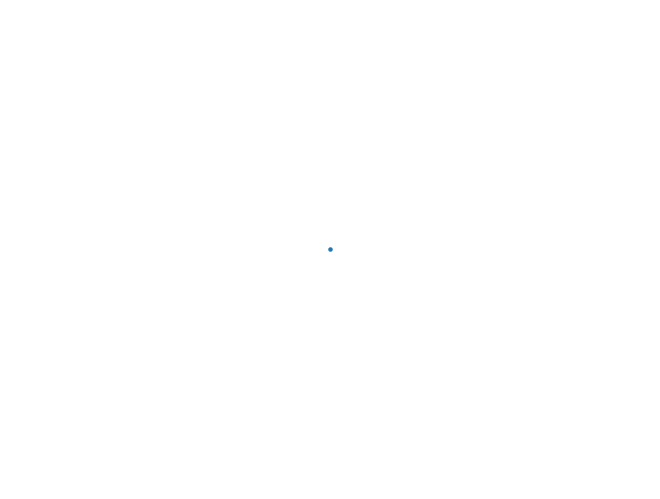

In [27]:
positions = {n: [n[0], n[1]] for n in list(starter_nodes.nodes)}
nx.draw(starter_nodes, positions, node_size=5)

In [28]:
cycles = sorted(find_all_cycles(geo_graph, source = [list(starter_nodes.nodes)[0]]), key = len)[::-1]

KeyboardInterrupt: 

In [34]:
polygons = [shapely.geometry.Polygon(shapely.geometry.Point(node) for node in cycle) for cycle in cycles]

In [35]:
# https://stackoverflow.com/a/47503098
non_overlapping = []
for n, p in enumerate(polygons[:-1], 1):
    if not any(p.overlaps(g) for g in polygons[n:]):
        non_overlapping.append(p)
final = gpd.GeoDataFrame(geometry = non_overlapping)

<AxesSubplot: >

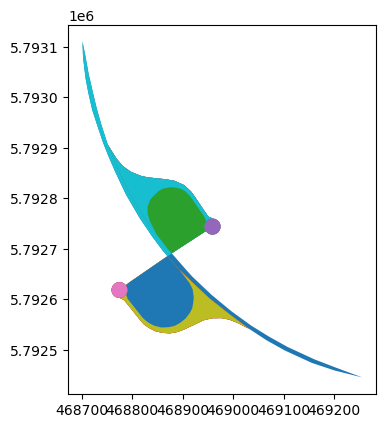

In [36]:
import matplotlib
cmap = matplotlib.cm.get_cmap('tab20c')
final["color"] = [cmap(x) for x in final.index]
final.plot(column = "color")

<AxesSubplot: >

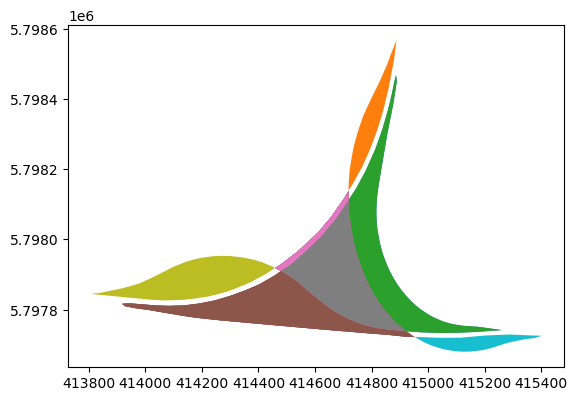

In [36]:
test = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg_polygons.geojson")
cmap = matplotlib.cm.get_cmap('tab20c')
test["color"] = [cmap(x) for x in test.index]
test.plot(column = "color")

In [71]:
import pandas as pd

In [67]:
test_bounds = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/test_bounds.geojson")
test_bboxes = test_bounds.bounds.apply(lambda bbox: shapely.geometry.Polygon([(bbox[0], bbox[1]),
                          (bbox[0], bbox[3]),
                          (bbox[2], bbox[3]),
                          (bbox[2], bbox[1])]), axis = 1)
test_ways = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/test_ways.geojson")

In [85]:
test_bboxes.index

RangeIndex(start=0, stop=207, step=1)

In [86]:
filtered = pd.concat([test_ways.intersects(test_bboxes[i]).map({True: test_bounds.group[i], False: pd.NA}) for i in test_bboxes.index], axis = 1).fillna(method='bfill', axis=1).iloc[:, 0]

In [87]:
test_ways["group"] = filtered
test_ways = test_ways.loc[~test_ways["group"].isna(),:]

In [88]:
test_ways

,access,area,bicycle,bicycle_road,bridge,busway,cycleway,foot,footway,highway,...,turn,width,id,timestamp,version,tags,osm_type,changeset,geometry,group
1,None,None,None,None,None,None,None,None,None,motorway,...,None,None,3996957,1503640498,29,"{'note:name': 'Der reg_name, sowie ggf. der lo...",way,NaN,"LINESTRING (370124.529 5796369.650, 369961.812...",[ 319 700 701 759 857 873 906 908 909 ...
5,None,None,None,None,None,None,None,None,None,motorway,...,None,None,4040468,1591384080,14,{'source:lit': 'http://www.autobahn-bilder.de'},way,NaN,"LINESTRING (305767.904 5907218.852, 305901.678...",[ 576 631 748 749 1023 1110 2329 2330]
6,None,None,None,None,None,None,None,None,None,motorway,...,None,None,4040469,1429824950,10,{'source:lit': 'http://www.autobahn-bilder.de'},way,NaN,"MULTILINESTRING ((313511.135 5901778.811, 3134...",[ 495 496 497 498 1963 1964 1965 1966 1967 ...
9,None,None,None,None,None,None,None,None,None,motorway,...,None,None,4040472,1429824965,14,{'source:lit': 'http://www.autobahn-bilder.de'},way,NaN,"MULTILINESTRING ((313046.147 5902088.661, 3131...",[ 495 496 497 498 1963 1964 1965 1966 1967 ...
11,None,None,None,None,None,None,None,None,None,motorway,...,None,None,4040476,1632395946,19,"{'placement': 'right_of:1', 'source:lit': 'htt...",way,NaN,"MULTILINESTRING ((318121.192 5897473.867, 3181...",[1026 1603 2325 2326]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60882,None,None,yes,None,None,None,no,None,None,tertiary,...,None,None,1104710114,1666019704,2,"{'lane_markings': 'no', 'name:etymology:wikida...",way,NaN,"MULTILINESTRING ((373698.424 5806883.074, 3736...",[ 155 156 157 158 279 280 282 283 284 ...
60883,None,None,yes,None,None,None,no,None,None,tertiary,...,None,None,1104710496,1666102525,3,"{'lane_markings': 'no', 'name:etymology:wikida...",way,NaN,"MULTILINESTRING ((373662.828 5806873.816, 3736...",[ 155 156 157 158 279 280 282 283 284 ...
60884,None,None,yes,None,None,None,no,None,None,tertiary,...,None,None,1104710577,1666102525,2,"{'lane_markings': 'no', 'name:etymology:wikida...",way,NaN,"MULTILINESTRING ((373601.074 5806856.539, 3735...",[ 155 156 157 158 279 280 282 283 284 ...
60963,None,None,use_sidepath,None,None,None,None,None,None,tertiary,...,None,None,1106910548,1666723254,1,{'postal_code': '14641'},way,NaN,"MULTILINESTRING ((362185.865 5823195.630, 3622...",[ 123 124 125 126 127 128 209 210 352 ...


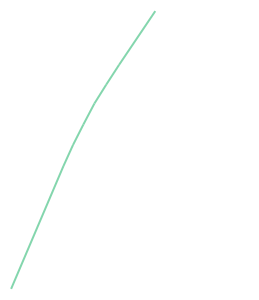

In [61]:
test_ways.geometry[0]

In [109]:
link_roads.geometry = link_roads.geometry.apply(lambda x: shapely.ops.unary_union(x))
adjunct_roads.geometry = adjunct_roads.geometry.apply(lambda x: shapely.ops.unary_union(x))

In [126]:
from itertools import chain

In [140]:
def union_worker(x):
    geo_list = list(chain(x.geoms))
    total_union = geo_list[0]
    for i in range(len(geo_list)):
        total_union = shapely.ops.unary_union([total_union, geo_list[i]])
    #geo_list = gpd.GeoDataFrame(geometry = [geo_list])
    return total_union

In [ ]:
driveways.groupby("group").geometry.apply(union_worker)

In [ ]:
# do a recursive union because a total unions crashes the kernel
total_union = test_4.geometry[0]
for i in range(test_3.shape[0]):
    test_4 = shapely.ops.unary_union([test_4, test_3.geometry.iloc[i]])
test_4 = gpd.GeoDataFrame(geometry = [test_4])

In [8]:
# do a recursive union because a total unions crashes the kernel
test_4 = test_4.geometry[0]
for i in range(test_3.shape[0]):
    test_4 = shapely.ops.unary_union([test_4, test_3.geometry.iloc[i]])
test_4 = gpd.GeoDataFrame(geometry = [test_4])

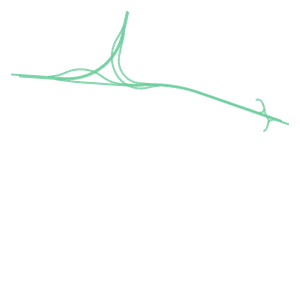

In [123]:
test_4.geometry[0]

In [10]:
import momepy
import networkx as nx

In [11]:
# create a network
geo_graph = momepy.gdf_to_nx(test_4.explode("geometry").reset_index(), approach = "primal")

/scratch/slurm_tmpdir/job_21339734/ipykernel_584591/4217093831.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geo_graph = momepy.gdf_to_nx(test_4.explode("geometry").reset_index(), approach = "primal")


(413500.0, 416000.0)

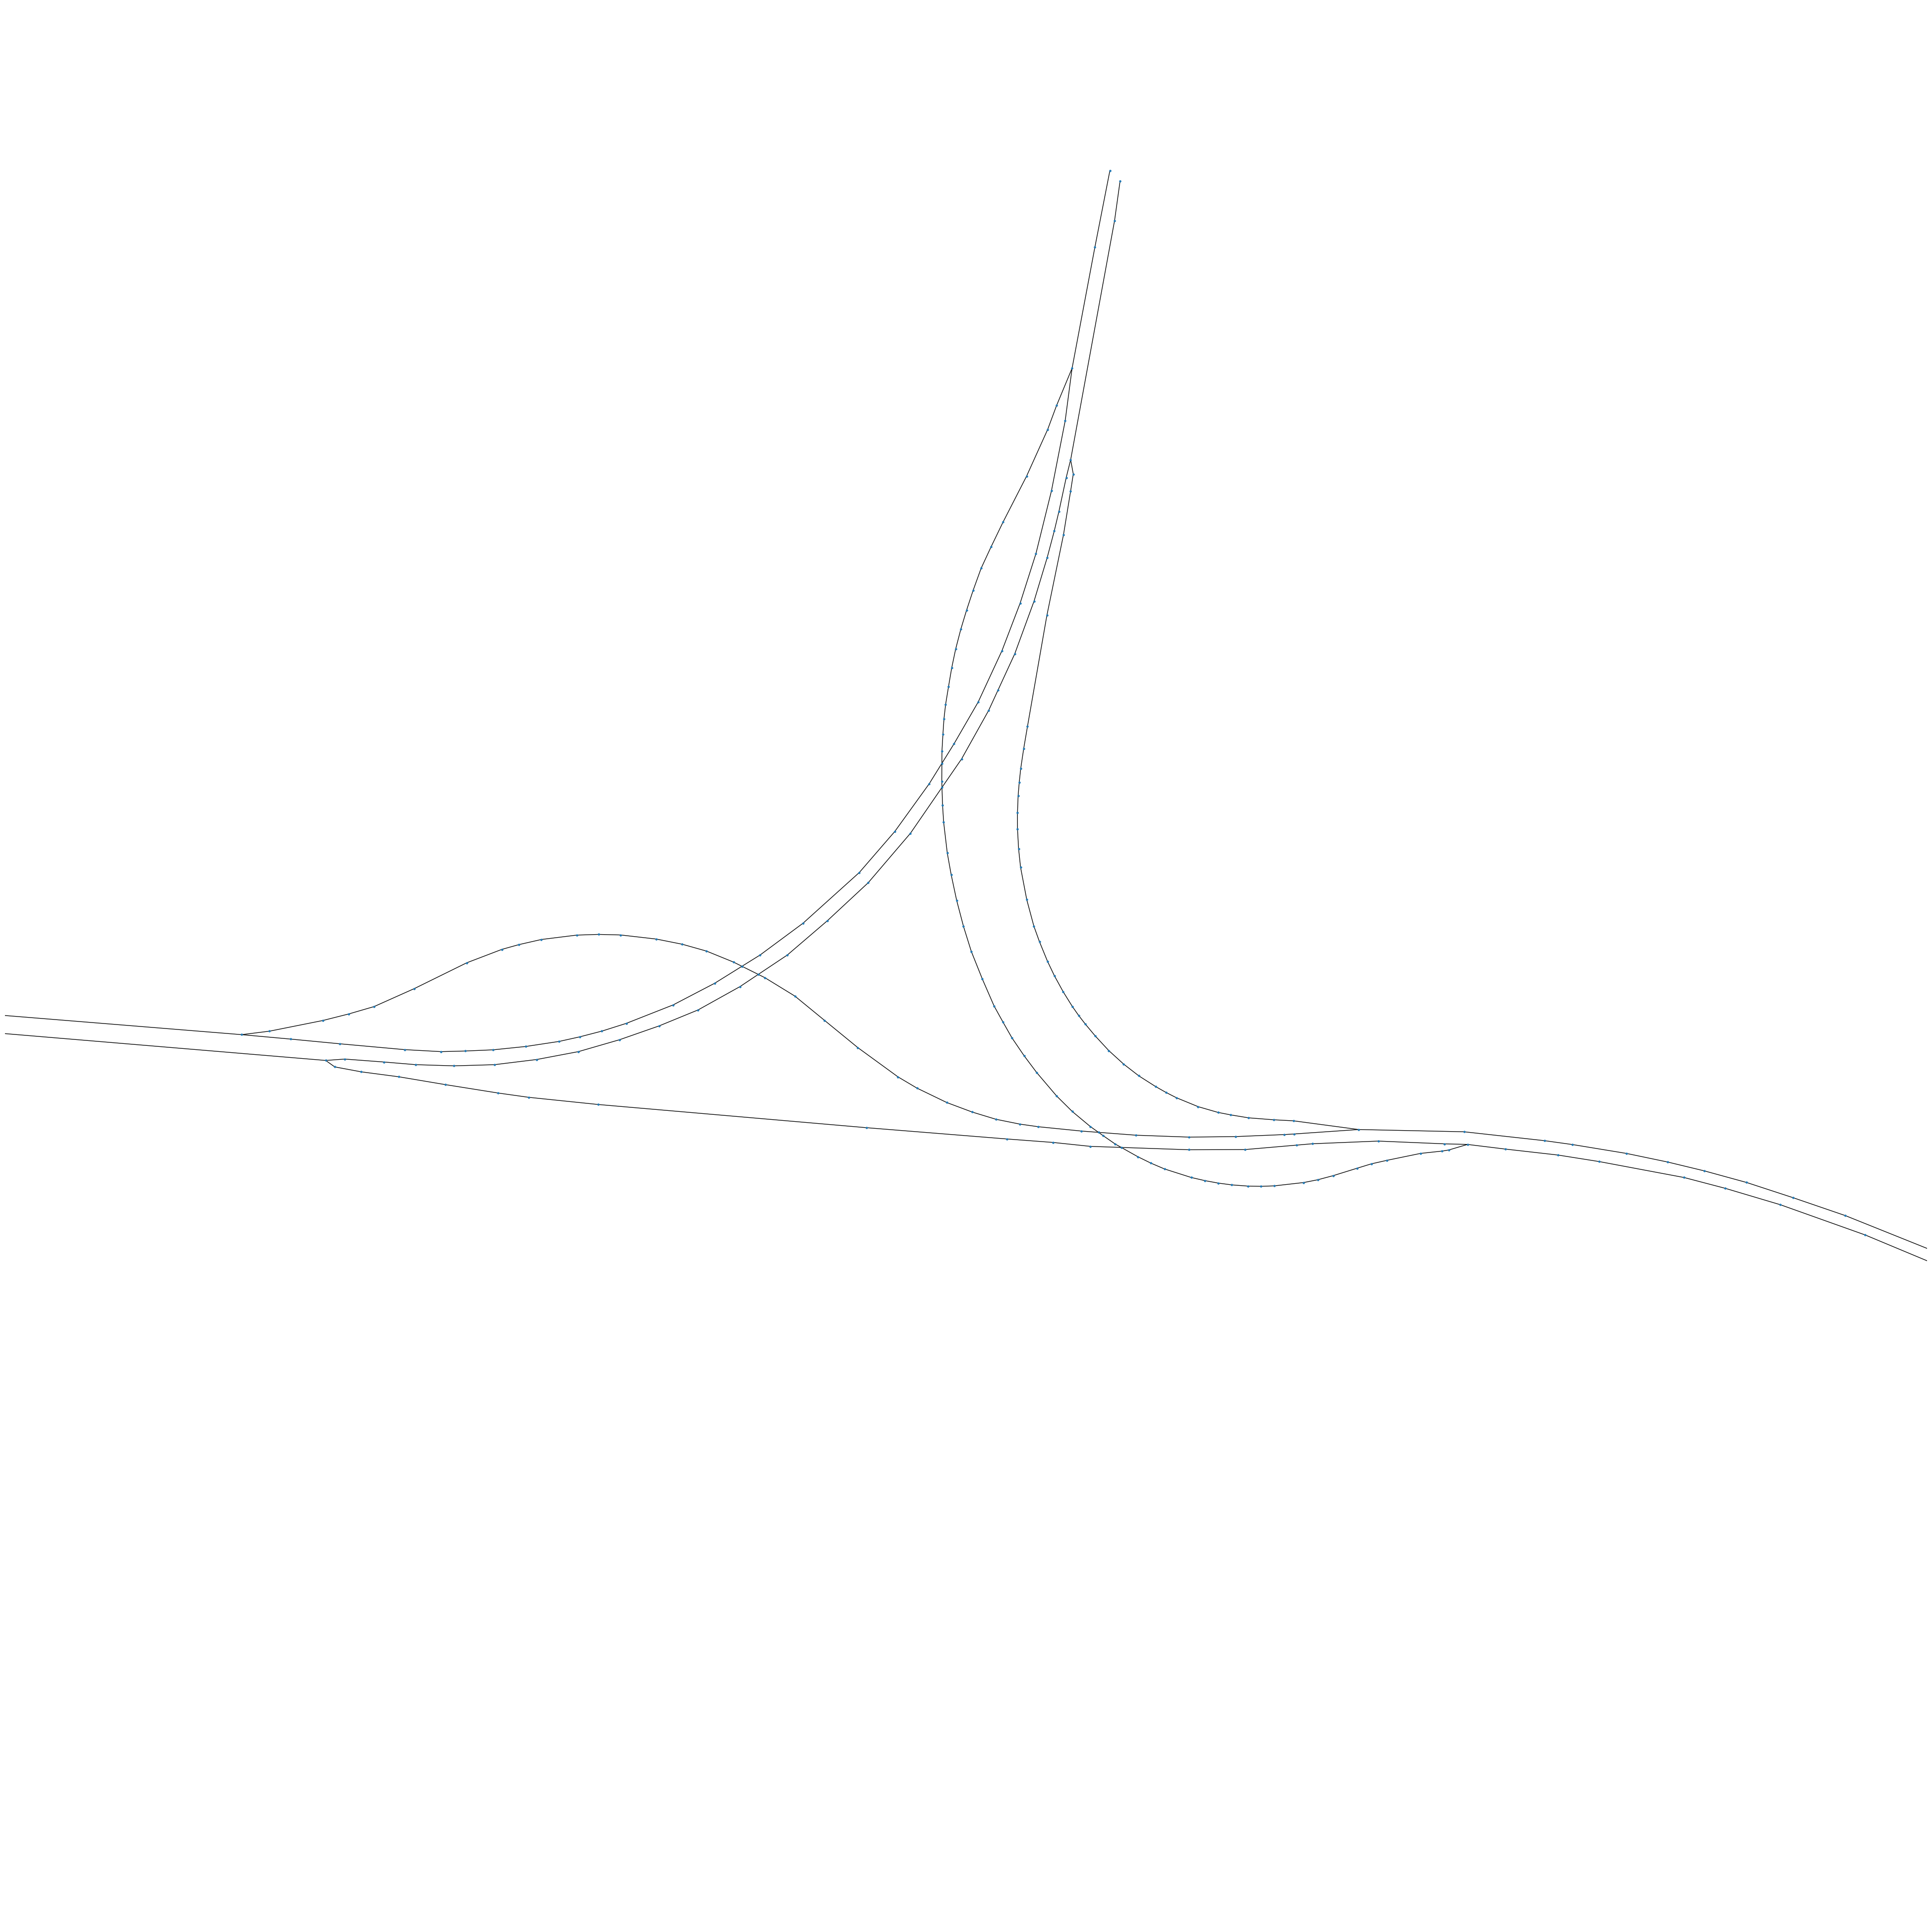

In [61]:
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}
fig, ax = plt.subplots(figsize = (50, 50))
nx.draw(geo_graph, positions, ax=ax, node_size=5)
ax.set_xlim([413500, 416000])

In [70]:
import numpy as np
#np.where(geo_graph.nodes == test.explode("geometry")["geometry"].apply(lambda x: x.coords[0]).iloc[0])
# [np.where(np.all(np.equal(list(geo_graph.nodes), test_6.iloc[i]), axis = 1))[0][0] for i in range(len(test_6))]

# get the first coord of each geometry
test_6 = test.explode("geometry")["geometry"].apply(lambda x: x.coords[0])[0]
test_6

/scratch/slurm_tmpdir/job_21324420/ipykernel_2075764/2217803328.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  np.where(geo_graph.nodes == test.explode("geometry")["geometry"].apply(lambda x: x.coords[0]).iloc[0])


(array([], dtype=int64),)

In [118]:
# find circles for each of the exploded starter nodes
test_7 = [x[2] for x in nx.find_cycle(geo_graph, source = test_6[172], orientation="ignore")]

/scratch/slurm_tmpdir/job_21324420/ipykernel_2075764/1779928606.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  test_4.explode("geometry").reset_index().iloc[test_7].plot()


<AxesSubplot: >

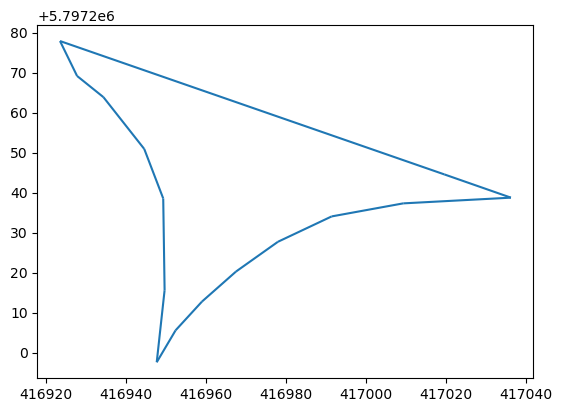

In [119]:
test_4.explode("geometry").reset_index().iloc[test_7].plot()

We only find a one circle per function call. The function `find_all_cycles()` might help. I have to make it work...

In [140]:
test_10 = nx.convert_node_labels_to_integers(geo_graph)

In [144]:
[i for i in nx.connected_components(test_10)]

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [142]:
find_all_cycles(test_10)

TypeError: 'set' object is not subscriptable

In [22]:
G = nx.path_graph(4)
nx.add_path(G, [10, 11, 12])
[i for i in nx.connected_components(G)]

[{0, 1, 2, 3}, {10, 11, 12}]

In [24]:
[len(x) for x in list(nx.connected_components(geo_graph))]

[288]

In [26]:
# create a network
starter_nodes = momepy.gdf_to_nx(test.explode("geometry").reset_index(), approach = "primal")

/scratch/slurm_tmpdir/job_21339734/ipykernel_584591/2802900751.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  starter_nodes = momepy.gdf_to_nx(test.explode("geometry").reset_index(), approach = "primal")


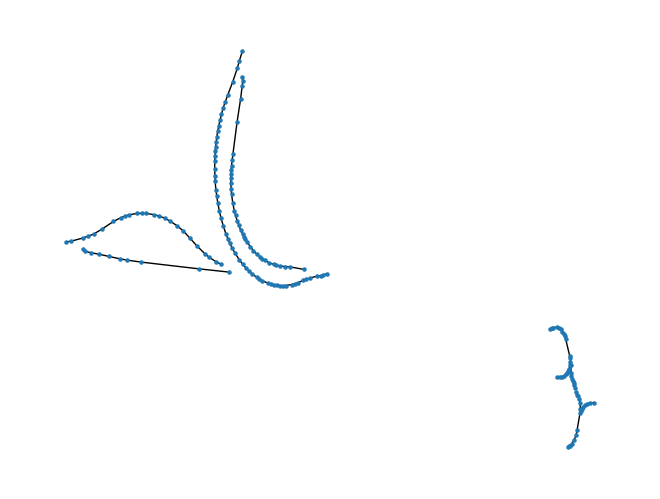

In [28]:
positions = {n: [n[0], n[1]] for n in list(starter_nodes.nodes)}
nx.draw(starter_nodes, positions, node_size=5)

In [114]:
test_11 = sorted(find_all_cycles(geo_graph, source = list(starter_nodes.nodes)), key = len)[::-1]

In [115]:
import numpy as np
colors = np.array([None] * len(geo_graph))

for cycle in range(len(test_11)):
    
    cycle_nodes = test_11[cycle]
    
    for node in range(len(cycle_nodes)):
        
        colors[np.where([x == test_11[cycle][node] for x in geo_graph.nodes])[0][0]] = cycle  

In [78]:
import matplotlib
cmap = matplotlib.cm.get_cmap('tab20c')

In [117]:
colors[colors == None] = 20

(413500.0, 416000.0)

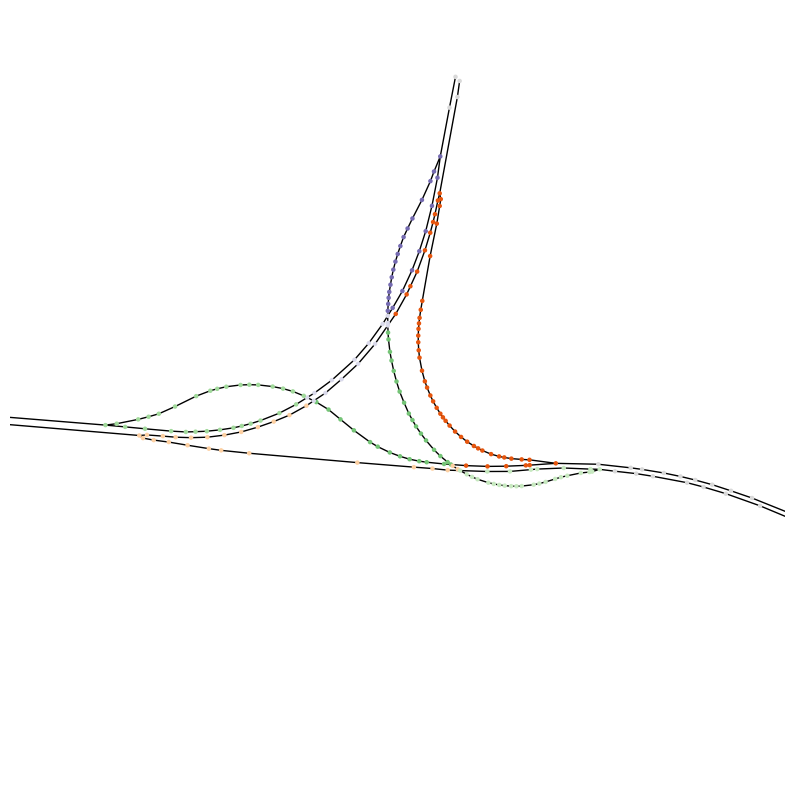

In [118]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 10))
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}
nx.draw(geo_graph, positions, ax=ax, node_color=[cmap(x) for x in colors], node_size=5)
ax.set_xlim([413500, 416000])

In [128]:
polygons = [shapely.geometry.Polygon(shapely.geometry.Point(node) for node in cycle) for cycle in test_11]

In [133]:
[x.area for x in polygons]

[177776.56053822915,
 172348.07569954393,
 119411.41949634526,
 113982.93465766001,
 56075.98027938293,
 121700.58025884634,
 116272.09542016117,
 58365.14104188404,
 63335.43921696238,
 57906.9543782771,
 42390.61741375024,
 11744.614620386796,
 17541.730589672126,
 2947.3929002092727,
 2491.800146348546,
 5428.484838685265]

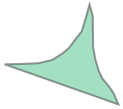

In [136]:
polygons[-3]

In [137]:
# https://stackoverflow.com/a/47503098
non_overlapping = []
for n, p in enumerate(polygons[:-1], 1):
    if not any(p.overlaps(g) for g in polygons[n:]):
        non_overlapping.append(p)

<AxesSubplot: >

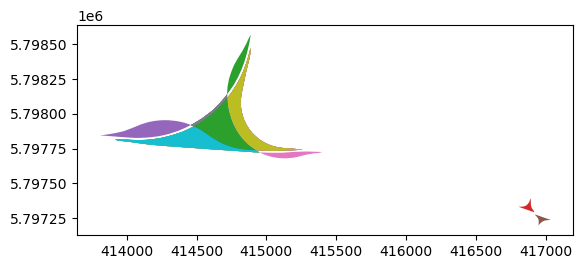

In [149]:
test_12 = gpd.GeoDataFrame(geometry = polygons)
test_12["color"] = [cmap(x) for x in test_12.index]
test_12.plot(column = "color")

<AxesSubplot: >

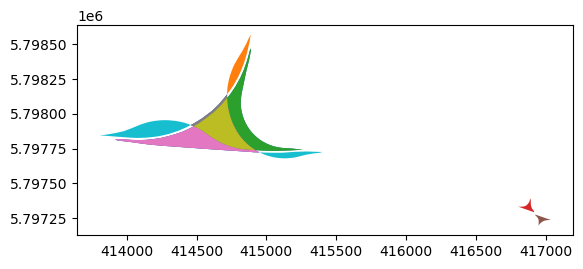

In [151]:
test_13 = gpd.GeoDataFrame(geometry = non_overlapping)
test_13["color"] = [cmap(x) for x in test_13.index]
test_13.plot(column = "color")

---

In [1]:
import xarray
import rioxarray
import geopandas as gpd

In [2]:
driveways = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/brandenburg.geojson")
imagery = rioxarray.open_rasterio('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/BB_ML_0002_2016-05-11.nc')
roads = driveways.loc[driveways.link_id == "BB_ML_0001"].dissolve(by = "link_id")

KeyboardInterrupt: 

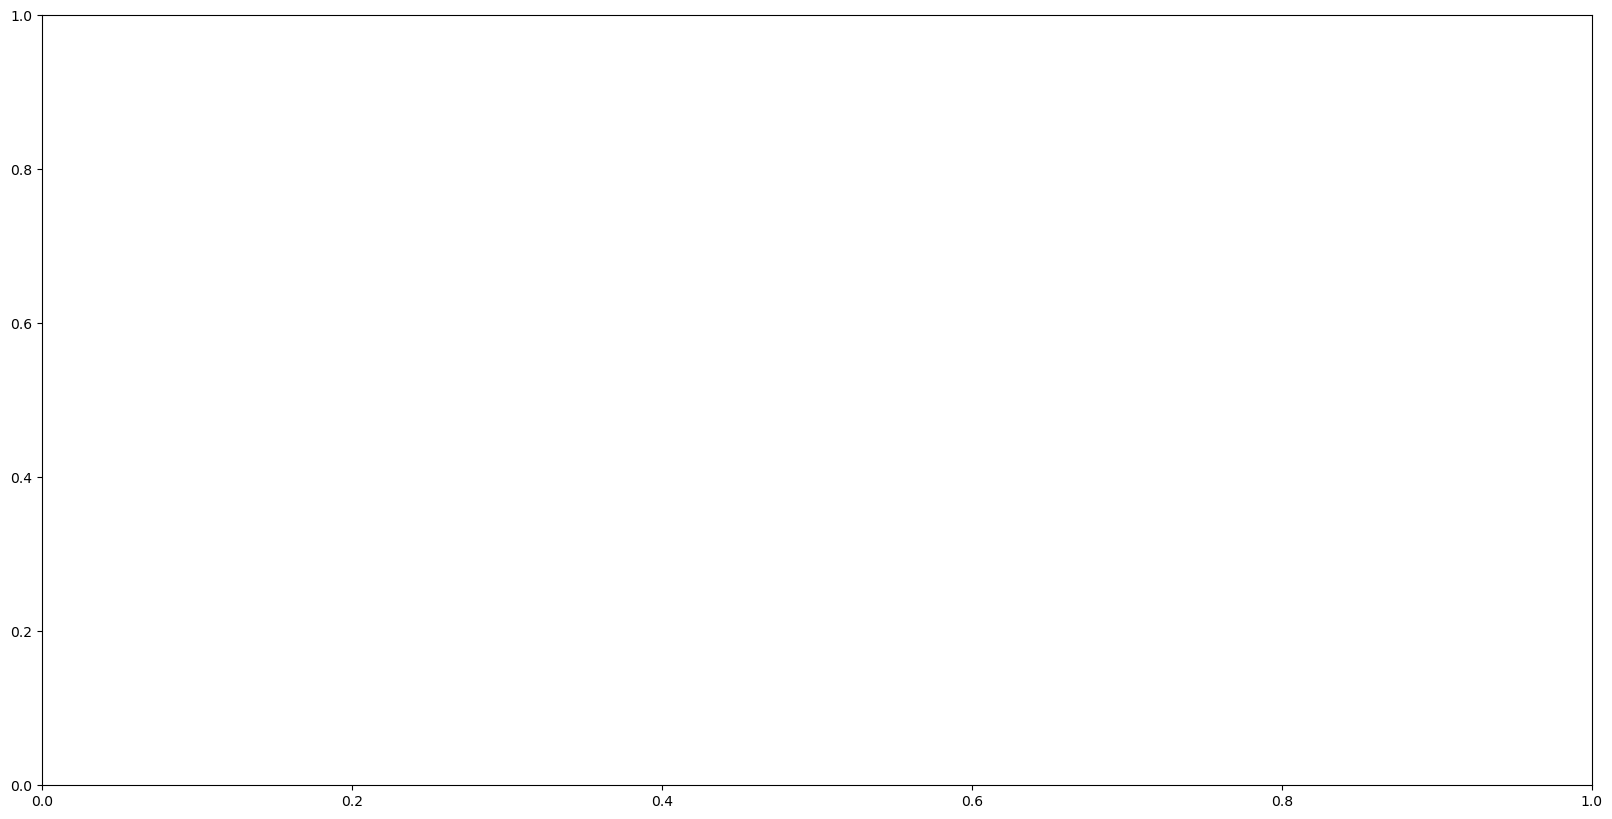

In [48]:
fig, ax = plt.subplots(figsize = (20, 10))
xarray.plot.imshow(imagery.red.squeeze("band", drop = True), ax = ax, cmap = "Greys")
roads.plot(ax = ax, color = "yellow")

In [37]:
# @https://gist.github.com/joe-jordan/6548029
def find_all_cycles(G, source=None, cycle_length_limit=None):
    """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
    types which work with min() and > ."""
    # produce edges for components with source
    nodes = source
        
    # extra variables for cycle detection:
    cycle_stack = []
    output_cycles = set()
    
    def get_hashable_cycle(cycle):
        """cycle as a tuple in a deterministic order."""
        m = min(cycle)
        mi = cycle.index(m)
        mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
        if cycle[mi-1] > cycle[mi_plus_1]:
            result = cycle[mi:] + cycle[:mi]
        else:
            result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
        return tuple(result)
    
    for start in nodes:
        if start in cycle_stack:
            continue
        cycle_stack.append(start)
        
        stack = [(start,iter(G[start]))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                
                if child not in cycle_stack:
                    cycle_stack.append(child)
                    stack.append((child,iter(G[child])))
                else:
                    i = cycle_stack.index(child)
                    if i < len(cycle_stack) - 2: 
                      output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                
            except StopIteration:
                stack.pop()
                cycle_stack.pop()
    
    return [list(i) for i in output_cycles]

### Module test and first download

In [ ]:
import os, sys
sys.path.append("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project")
from modules.data.data_driveways import data_driveways

In [ ]:
test = data_driveways()

In [ ]:
driveways = test.query("brandenburg")

--- Your chosen federal state has 1 government district(s). ---
Loading Regional Data...
--- The OSM data has been loaded successfully. ---
Reorganizing and Identification...
--- 162 Driveways were found in the area of interest. ---
--- 1 of 1 government districts are processed. ---


<AxesSubplot: >

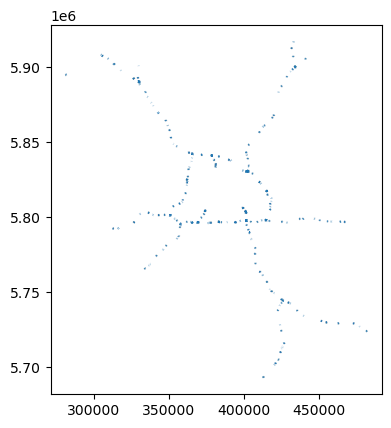

In [ ]:
driveways.plot()

In [9]:
driveways.bounds.loc[((driveways.bounds.minx > 414300)& (driveways.bounds.minx < 414302))]

,minx,miny,maxx,maxy
5,414300.566367,5.797393e+06,416889.719977,5.798567e+06


In [11]:
import os, sys
sys.path.append("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project")
from modules.data.data_imagery import data_imagery

In [12]:
imagery_downloader = data_imagery("brandenburg")

['WMS BB-BE DOP20 2016-2018', 'Dieser Web Map Service stellt digitale farbige und graue Orthophotos (Luftbilder) mit der Bodenauflösung von 20cm vom Gebiet Brandenburg (2016-2018)/Berlin (2017) zur Verfügung.']
['WFS BB Aktualitäten-LGB', 'Dieser Web Feature Service stellt die Aktualitätsübersichten der LGB-Produkte zum Download bereit.']


In [14]:
(driveways.bounds.iloc[26][2] - driveways.bounds.iloc[26][0],
 driveways.bounds.iloc[26][3] - driveways.bounds.iloc[26][1])

(1976.1360366793815, 2791.1445457134396)

In [15]:
(driveways.bounds.iloc[25][2] - driveways.bounds.iloc[25][0],
 driveways.bounds.iloc[25][3] - driveways.bounds.iloc[25][1])

(400.1310606790357, 703.4619901608676)

In [15]:
import xarray
import rioxarray

In [16]:
xa = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/brandenburg_361762_5822773_362545_5825330_2018-05-04.nc")

In [8]:
driveways.bounds.values[26]

array([ 399260.5112895 , 5803334.14603802,  401236.64732618,
       5806125.29058373])

In [17]:
xa["red"].plot()

In [13]:
imagery_downloader.query(driveways.bounds.values)

--- Querying for image 1 ---
--- Querying for image 2 ---
--- Querying for image 3 ---
--- Querying for image 4 ---
--- Querying for image 5 ---
--- Querying for image 6 ---
--- Querying for image 7 ---
--- Querying for image 8 ---
--- Querying for image 9 ---
--- Querying for image 10 ---
--- Querying for image 11 ---
--- Querying for image 12 ---
--- Querying for image 13 ---
--- Querying for image 14 ---
--- Querying for image 15 ---
--- Querying for image 16 ---
--- Querying for image 17 ---
--- Querying for image 18 ---
--- Querying for image 19 ---
--- Querying for image 20 ---
--- Querying for image 21 ---
--- Querying for image 22 ---
--- Querying for image 23 ---
--- Querying for image 24 ---
--- Querying for image 25 ---
--- Querying for image 26 ---
--- Querying for image 27 ---
--- Querying for image 28 ---
--- Querying for image 29 ---
--- Querying for image 30 ---
--- Querying for image 31 ---
--- Querying for image 32 ---
--- Querying for image 33 ---
--- Querying for im

KeyboardInterrupt: 

In [16]:
from owslib.wms import WebMapService
from owslib.wfs import WebFeatureService
from bs4 import BeautifulSoup
from numpy import asarray, expand_dims, arange
from io import BytesIO
from PIL import Image
from xarray import Dataset
from geopandas import GeoSeries
from shapely.geometry import Polygon

In [15]:
# calculates the output image size according to the provided density and bbox
def __calculate_image_size(bbox):
    return([((bbox[2] - bbox[0]) / pixel_density), 
            ((bbox[3] - bbox[1]) / pixel_density)])
pixel_density = .2

In [17]:
wms = WebMapService("https://isk.geobasis-bb.de/mapproxy/dop20_2016_2018/service/wms?", version='1.1.1')

In [20]:
wfs = WebFeatureService("https://isk.geobasis-bb.de/ows/aktualitaeten_wfs?", version='1.1.0')

In [19]:
query_bbox = driveways.bounds.values[0]
            
# query the imagery from the WMS service
img = wms.getmap(
    layers = ["dop20_bebb_2016_2018_farbe"],
    srs = "EPSG:25833",
    bbox = query_bbox,
    size = __calculate_image_size(query_bbox),
    format = "image/jpeg").read()

In [24]:
wfs.getfeature(typename = "app:dop20rgbi_2016_2018_single",
               bbox = tuple(query_bbox), 
               srsname = "EPSG:25833").read()

b'<?xml version=\'1.0\' encoding=\'UTF-8\'?>\n<wfs:FeatureCollection xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/wfs http://schemas.opengis.net/wfs/1.1.0/wfs.xsd http://www.deegree.org/app https://isk.geobasis-bb.de/ows/aktualitaeten_wfs?SERVICE=WFS&amp;VERSION=1.1.0&amp;REQUEST=DescribeFeatureType&amp;OUTPUTFORMAT=text%2Fxml%3B+subtype%3Dgml%2F3.1.1&amp;TYPENAME=app:dop20rgbi_2016_2018_single&amp;NAMESPACE=xmlns(app=http%3A%2F%2Fwww.deegree.org%2Fapp)" xmlns:wfs="http://www.opengis.net/wfs" timeStamp="2022-11-21T08:57:47Z" xmlns:gml="http://www.opengis.net/gml">\n  <gml:featureMember>\n    <app:dop20rgbi_2016_2018_single xmlns:app="http://www.deegree.org/app" gml:id="dop20rgbi_2016_2018_single_9069">\n      <app:classification>single</app:classification>\n      <app:identifier>95661368-5058-4513-8d72-87050aa9b1d2</app:identifier>\n      <app:sheetnr>33328-5890</app:sheetnr>\n      <app:creationdate>2017-05-27</app:creationdate>\n   

In [ ]:
for bbox in spatial_bounds:
            
            query_bbox = bbox
            
            # query the imagery from the WMS service
            img = self.wms.getmap(
                layers = ["dop20_bebb_2016_2018_farbe"],
                srs = "EPSG:25833",
                bbox = query_bbox,
                size = self.__calculate_image_size(query_bbox),
                format = "image/jpeg").read()
            
            # query timestamp from the WFS service
            wfs_response = self.wfs.getfeature(typename = self.wfs_typename,
                                               bbox = query_bbox, 
                                               srsname = "EPSG:" + str(self.import_crs)).read()
            timestamp = BeautifulSoup(wfs_response, features = "xml").find(self.wfs_datepos).text
            
            # export as jpg first
            with open(self.storage_directory + "/" + self.state + 
                      "_" + "_".join([str(x) for x in query_bbox]) + "_" + timestamp + ".jpg", "wb") as file:
                file.write(img)
            
            # turn jpg into numpy array
            tmp_np = asarray(Image.open(BytesIO(img)))
            
            # create xarray
            tmp_xd = Dataset(data_vars = {"red": (["x", "y"], tmp_np[:,:,0]),
                                          "green": (["x", "y"], tmp_np[:,:,1]),
                                          "blue": (["x", "y"], tmp_np[:,:,2])},
                             coords = {"x": (["x"], arange(tmp_np.shape[0]) * self.pixel_density + query_bbox[0]),
                                       "y": (["y"], arange(tmp_np.shape[1]) * self.pixel_density + query_bbox[1])})
            # convert type
            tmp_xd = tmp_xd.astype("int")
            # set output crs
            tmp_xd.rio.write_crs(25833, inplace = True)
            tmp_xd.rio.set_spatial_dims(x_dim = "x", y_dim = "y", inplace = True)
            tmp_xd.rio.write_coordinate_system(inplace = True)
            tmp_xd.rio.write_transform(inplace = True)
            # export the nc
            with open(self.storage_directory + "/" + self.state + 
                      "_" + "_".join([str(x) for x in query_bbox]) + "_" + timestamp + ".nc", "wb") as file:
                tmp_xd.to_netcdf(file)
                
            n += 1
            
        print("Successfully queried and exported " + str(n) + " images")

In [14]:
driveways.bounds.values[0]

array([ 329521.01944983, 5890367.72786754,  329853.53228281,
       5890726.1518467 ])

---

In [1]:
from owslib.wms import WebMapService
from owslib.wfs import WebFeatureService

In [10]:
wms = WebMapService("https://www.geodatenportal.sachsen-anhalt.de/wss/service/ST_LVermGeo_GDI_DOP20/guest?", version='1.3.0')

In [11]:
list(wms.contents)

['lsa_lvermgeo_dop20']

In [5]:
wms['DOP_belaubt_highres'].crsOptions

['EPSG:4326',
 'CRS:84',
 'EPSG:3044',
 'EPSG:3857',
 'EPSG:25833',
 'EPSG:31467',
 'EPSG:25832',
 'EPSG:4258']

In [6]:
wms['DOP_belaubt_highres'].styles

{'default': {'title': 'default',
  'legend': 'https://geodienste.hamburg.de/HH_WMS_DOP_belaubt?language=ger&version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=DOP_belaubt&format=image/png&STYLE=default',
  'legend_width': '35',
  'legend_height': '5',
  'legend_format': 'image/png'}}

In [7]:
wms.getOperationByName('GetMap').formatOptions

['image/png',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8',
 'application/x-pdf',
 'image/svg+xml',
 'image/tiff',
 'application/vnd.google-earth.kml+xml',
 'application/vnd.google-earth.kmz',
 'application/x-protobuf',
 'application/json']

In [4]:
import geopandas as gpd
import PIL
from io import BytesIO

In [12]:
data = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/OSM/processed/sachsen-anhalt_polygons.geojson")

In [13]:
# calculates the output image size according to the provided density and bbox
def __calculate_image_size(bbox):
    return([((bbox[2] - bbox[0]) / pixel_density), 
            ((bbox[3] - bbox[1]) / pixel_density)])
pixel_density = .2

In [21]:
tmp = [int(x) for x in data.iloc[[1]].total_bounds]
#tmp[2] = tmp[0] + 10
#tmp[3] = tmp[1] + 2

In [25]:
tmp[2] = tmp[0] + 50
tmp[3] = tmp[1] + 10

In [26]:
# query the imagery from the WMS service
img = wms.getmap(
    layers = ["lsa_lvermgeo_dop20"],
    srs = "EPSG:25833",
    bbox = tmp,
    size = [int(x) for x in __calculate_image_size(tmp)],
    format = "image/jpeg").read()

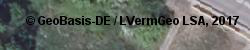

In [27]:
from PIL import Image
Image.open(BytesIO(img))

In [49]:
test.save("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.jpg")

In [25]:
import feedparser

feed = feedparser.parse("https://www.geodaten-mv.de/dienste/dop20_atom?type=service&amp;id=695ab0a0-71f8-481c-b83e-b67a3688f5b0")

In [26]:
feed

{'bozo': False,
 'entries': [{'inspire_dls_spatial_dataset_identifier_code': 'f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
   'inspire_dls_spatial_dataset_identifier_namespace': 'https://www.geodaten-mv.de',
   'tags': [{'term': 'http://www.opengis.net/def/crs/EPSG/0/25833',
     'scheme': None,
     'label': 'EPSG:25833'}],
   'id': 'https://www.geodaten-mv.de/dienste/dop20_atom?type=dataset&id=f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
   'guidislink': True,
   'link': 'https://www.geodaten-mv.de/dienste/dop20_atom?type=dataset&id=f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
   'links': [{'rel': 'describedby',
     'href': 'https://www.geodaten-mv.de/soapServices/api?service=CSW&version=2.0.2&request=GetRecordById&outputSchema=http://www.isotc211.org/2005/gmd&ElementSetName=full&Id=bcfae1e9-1e22-47dd-92ea-1901308b9b74',
     'type': 'application/xml'},
    {'rel': 'alternate',
     'href': 'https://www.geodaten-mv.de/dienste/dop20_atom?type=dataset&id=f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
     'typ

In [27]:
feed.entries

[{'inspire_dls_spatial_dataset_identifier_code': 'f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
  'inspire_dls_spatial_dataset_identifier_namespace': 'https://www.geodaten-mv.de',
  'tags': [{'term': 'http://www.opengis.net/def/crs/EPSG/0/25833',
    'scheme': None,
    'label': 'EPSG:25833'}],
  'id': 'https://www.geodaten-mv.de/dienste/dop20_atom?type=dataset&id=f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
  'guidislink': True,
  'link': 'https://www.geodaten-mv.de/dienste/dop20_atom?type=dataset&id=f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
  'links': [{'rel': 'describedby',
    'href': 'https://www.geodaten-mv.de/soapServices/api?service=CSW&version=2.0.2&request=GetRecordById&outputSchema=http://www.isotc211.org/2005/gmd&ElementSetName=full&Id=bcfae1e9-1e22-47dd-92ea-1901308b9b74',
    'type': 'application/xml'},
   {'rel': 'alternate',
    'href': 'https://www.geodaten-mv.de/dienste/dop20_atom?type=dataset&id=f94d17fa-b29b-41f7-a4b8-6e10f1aae38e',
    'type': 'application/atom+xml',
    'hreflang